In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from kmodes.kprototypes import KPrototypes

from duped_modules.dcn_duped import DCNDuped
from duped_modules.dec_duped import DECDuped, IDECDuped
from duped_modules.embeddings_autoencoder import EmbeddingsAutoencoder
from duped_modules.gower_duped import gower_matrix as gower_matrix_duped

Clump_thickness  Uniformity_of_cell_size  Uniformity_of_cell_shape   
0                  4                        0                         0  \
1                  4                        3                         3   
2                  2                        0                         0   
3                  5                        7                         7   
4                  3                        0                         0   
..               ...                      ...                       ...   
694                2                        0                         0   
695                1                        0                         0   
696                4                        9                         9   
697                3                        7                         5   
698                3                        7                         7   

     Marginal_adhesion  Single_epithelial_cell_size  Bare_nuclei   
0                    0                            1            0  \
1                    4                            6            1   
2                    0                            1            2   
3                    0                            2            4   
4                    2                            1            0   
..                 ...                          ...          ...   
694                  0                            2            2   
695                  0                            1            0   
696                  2                            6            3   
697                  3                            2            4   
698                  4                            3            5   

     Bland_chromatin  Normal_nucleoli  Mitoses  
0                  2                0        0  
1                  2                1        0  
2                  2                0        0  
3                  2                6        0  
4                  2                0        0  
..               ...              ...      ...  
694                0                0        0  
695                0                0        0  
696                7                9        1  
697                9                5        0  
698                9                3        0  

[699 rows x 9 columns]

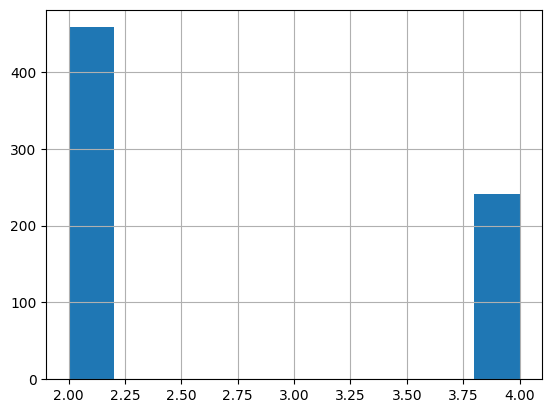

In [2]:
breast_df = pd.read_csv("datasets/breast_cancer.csv")

breast_y = breast_df["Class"]
breast_y.hist()
breast_df.drop(columns=["Sample_code_number", "Class"], axis=1, inplace=True)

breast_cat_cols = breast_df.columns.values
breast_cont_cols = []

breast_df[breast_cat_cols] = breast_df[breast_cat_cols].apply(LabelEncoder().fit_transform)
breast_df

job  marital  education  default   balance  housing  loan  contact   
0       10        1          0        0  0.139496        0     0        0  \
1        7        1          1        0  1.125461        1     1        0   
2        4        2          2        0 -0.004031        1     0        0   
3        4        1          2        0  0.037352        1     1        2   
4        1        1          1        0 -0.447419        1     0        2   
...    ...      ...        ...      ...       ...      ...   ...      ...   
49727    9        1          2        0 -0.176460        0     0        0   
49728    5        0          0        0  0.120447        0     0        0   
49729    5        1          1        0  1.429593        0     0        0   
49730    1        1          1        0 -0.228024        0     0        1   
49731    2        1          1        0  0.528364        0     0        0   

       duration  campaign     pdays  previous  poutcome  
0     -0.695712 -0.569351 -0.411453 -0.251940         3  
1     -0.148192 -0.569351  2.984213  1.484611         0  
2     -0.284101 -0.569351  2.894327  0.182198         0  
3     -0.229737  0.399020 -0.411453 -0.251940         3  
4     -0.124893 -0.569351 -0.411453 -0.251940         3  
...         ...       ...       ...       ...       ...  
49727  2.791329  0.076230 -0.411453 -0.251940         3  
49728  0.768224 -0.246560 -0.411453 -0.251940         3  
49729  3.373797  0.721811  1.436189  1.050473         2  
49730  0.970146  0.399020 -0.411453 -0.251940         3  
49731  0.399328 -0.246560  1.476138  4.523577         1  

[45211 rows x 13 columns]

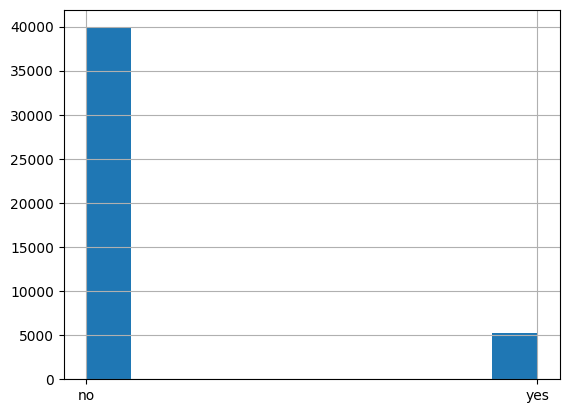

In [3]:
banking_df = pd.read_csv("datasets/banking_marketing.csv", sep=";")
banking_df.drop_duplicates(inplace=True)

banking_y = banking_df["y"]
banking_y.hist()
banking_y = LabelEncoder().fit_transform(banking_y)

banking_cat_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]
banking_cont_cols = ["balance", "duration", "campaign", "pdays", "previous"]

banking_df.drop(columns=["age", "y", "day", "month"], axis=1, inplace=True)
banking_df[banking_cat_cols] = banking_df[banking_cat_cols].apply(LabelEncoder().fit_transform)
banking_df[banking_cont_cols] = StandardScaler().fit_transform(banking_df[banking_cont_cols])
banking_df

age  workclass    fnlwgt  education  education-num   
0      0.025724          7 -1.061993          9       1.136595  \
1      0.828125          6 -1.007118          9       1.136595   
2     -0.047221          4  0.245993         11      -0.419685   
3      1.046961          4  0.426618          1      -1.197826   
4     -0.776676          4  1.408464          9       1.136595   
...         ...        ...       ...        ...            ...   
48837  0.025724          4  0.243843          9       1.136595   
48838  1.849362          0  1.247430         11      -0.419685   
48839 -0.047221          4  1.754792          9       1.136595   
48840  0.390452          4 -1.001626          9       1.136595   
48841 -0.266058          5 -0.071208          9       1.136595   

       marital-status  occupation  relationship  race  sex  capital-gain   
0                   4           1             1     4    1      0.146804  \
1                   2           4             0     4    1     -0.144847   
2                   0           6             1     4    1     -0.144847   
3                   2           6             0     2    1     -0.144847   
4                   2          10             5     2    0     -0.144847   
...               ...         ...           ...   ...  ...           ...   
48837               0          10             1     4    0     -0.144847   
48838               6           0             2     2    1     -0.144847   
48839               2          10             0     4    1     -0.144847   
48840               0           1             3     1    1      0.586964   
48841               2           4             0     4    1     -0.144847   

       capital-loss  hours-per-week  native-country  
0         -0.217195       -0.034304              39  
1         -0.217195       -2.213335              39  
2         -0.217195       -0.034304              39  
3         -0.217195       -0.034304              39  
4         -0.217195       -0.034304               5  
...             ...             ...             ...  
48837     -0.217195       -0.357123              39  
48838     -0.217195       -0.034304              39  
48839     -0.217195        0.772745              39  
48840     -0.217195       -0.034304              39  
48841     -0.217195        1.579794              39  

[48813 rows x 14 columns]

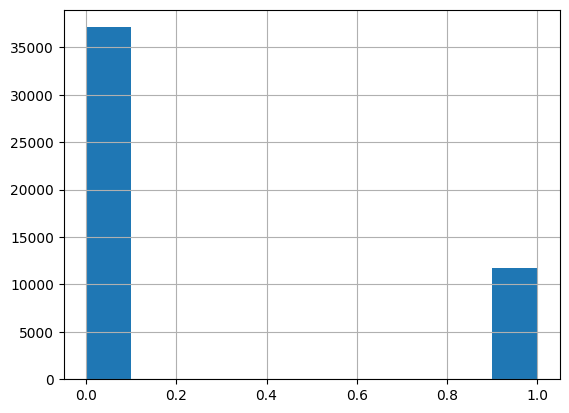

In [4]:
census_df = pd.read_csv("datasets/census_income.csv")
census_df.drop_duplicates(inplace=True)

census_df.loc[(census_df["class"] == " <=50K.") | (census_df["class"] == " <=50K"), "class"] = 0
census_df.loc[(census_df["class"] == " >50K.") | (census_df["class"] == " >50K"), "class"] = 1
census_df["class"].hist()
census_y = census_df["class"].to_numpy()

census_cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
census_cont_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

census_df.drop(columns="class", inplace=True)
census_df[census_cat_cols] = census_df[census_cat_cols].apply(LabelEncoder().fit_transform)
census_df[census_cont_cols] = StandardScaler().fit_transform(census_df[census_cont_cols])
census_df

A1        A2        A3  A4  A5  A6  A7        A8  A9  A10       A11  A12   
0     1 -0.056962 -0.961440   1   0  12   7 -0.295171   1    1 -0.302596    0  \
1     0  2.296536 -0.073565   1   0  10   3  0.236217   1    1  0.704516    0   
2     0 -0.592078 -0.861903   1   0  10   3 -0.220955   1    0 -0.504019    0   
3     1 -0.310572 -0.654865   1   0  12   7  0.446990   1    1  0.503093    1   
4     1 -0.958122  0.158358   1   0  12   7 -0.158613   1    0 -0.504019    0   
..   ..       ...       ...  ..  ..  ..  ..       ...  ..  ...       ...  ...   
685   1 -0.881193  1.046233   2   2   4   3 -0.295171   0    0 -0.504019    0   
686   0 -0.746780 -0.812134   1   0   1   7 -0.072523   0    1 -0.101174    1   
687   0 -0.528676  1.726075   2   2   5   2 -0.072523   0    1 -0.302596    1   
688   1 -1.148329 -0.920630   1   0   0   7 -0.654378   0    0 -0.504019    0   
689   1  0.295556 -0.289561   1   0   1   3  1.794756   0    0 -0.504019    1   

     A13       A14       A15  
0      0  0.128682 -0.193125  
1      0 -0.816802 -0.086443  
2      0  0.592504 -0.036150  
3      0 -0.477855 -0.192553  
4      2 -0.358926 -0.193125  
..   ...       ...       ...  
685    0  0.473575 -0.193125  
686    0  0.116789 -0.118066  
687    0  0.116789 -0.192934  
688    0  0.592504 -0.050247  
689    0 -1.072499 -0.193125  

[653 rows x 15 columns]

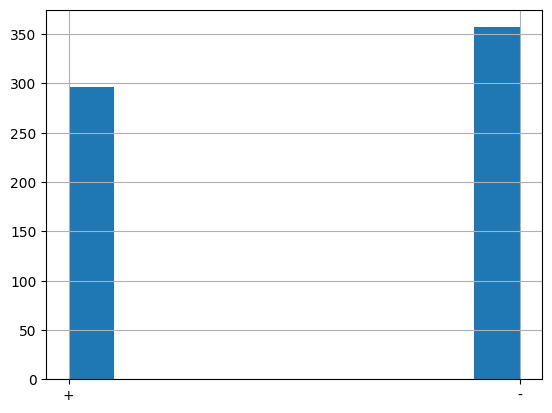

In [5]:
credit_df = pd.read_csv("datasets/credit_approval.csv")
credit_df.replace("?", pd.NA, inplace=True)
credit_df.dropna(inplace=True)
credit_df.drop_duplicates(inplace=True)

credit_y = credit_df["A16"]
credit_y.hist()
credit_y = LabelEncoder().fit_transform(credit_y)

credit_cat_cols = ["A1", "A4", "A5", "A6", "A7", "A9", "A10", "A12", "A13"]
credit_cont_cols = ["A2", "A3", "A8", "A11", "A14", "A15"]

credit_df.drop(columns="A16", inplace=True)
credit_df[credit_cat_cols] = credit_df[credit_cat_cols].apply(LabelEncoder().fit_transform)
credit_df[credit_cont_cols] = StandardScaler().fit_transform(credit_df[credit_cont_cols])
credit_df

age  sex  cp  trestbps      chol  fbs  restecg    thalch  exang   
0    0.940446    1   3  0.749760 -0.262867    1        0  0.029124      0  \
1    1.384143    1   0  1.596354  0.747722    0        0 -1.790447      1   
2    1.384143    1   0 -0.661231 -0.339138    0        0 -0.880662      1   
3   -1.943588    1   2 -0.096835  0.061285    0        1  1.632079      0   
4   -1.499891    0   1 -0.096835 -0.815830    0        0  0.982232      0   
..        ...  ...  ..       ...       ...  ...      ...       ...    ...   
299  1.495068    1   0  0.693320 -1.025575    1        1 -0.360784      0   
300  0.274900    1   0 -0.096835 -2.207774    0        1 -1.487186      1   
301  0.274900    0   1 -0.096835 -0.205664    0        0  1.068878      0   
508 -0.834344    1   0  1.031958 -0.396341    0        1 -2.223678      1   
748  0.163975    1   0 -0.661231 -2.798873    0        1 -1.270570      1   

      oldpeak  slope        ca  thal  
0    1.069475      0 -0.718306     0  
1    0.380309      1  2.487269     1  
2    1.327912      1  1.418744     2  
3    2.103224      0 -0.718306     1  
4    0.294163      2 -0.718306     1  
..        ...    ...       ...   ...  
299  2.017078      1  1.418744     2  
300  0.121872      1  0.350219     2  
301 -0.911877      1  0.350219     1  
508  0.380309      1 -0.718306     2  
748  0.380309      1 -0.718306     2  

[299 rows x 13 columns]

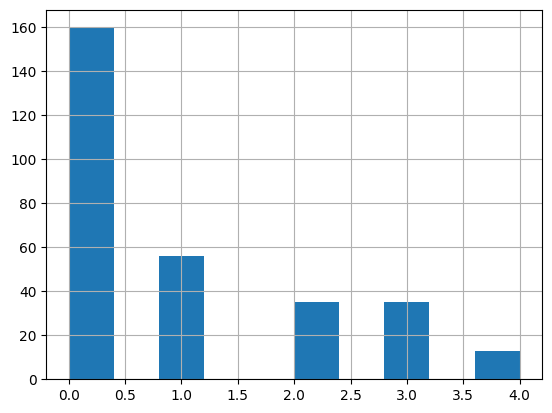

In [6]:
heart_df = pd.read_csv("datasets/heart_disease.csv")
heart_df.dropna(inplace=True)
heart_df.drop_duplicates(inplace=True)

heart_df["num"].hist()
heart_y = heart_df["num"].to_numpy()

heart_cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
heart_cont_cols = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]

heart_df.drop(columns=["id", "dataset", "num"], inplace=True)
heart_df.dropna(inplace=True)

heart_df[heart_cat_cols] = heart_df[heart_cat_cols].apply(LabelEncoder().fit_transform)
heart_df[heart_cont_cols] = StandardScaler().fit_transform(heart_df[heart_cont_cols])
heart_df

In [7]:
class BreastDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[breast_cat_cols].values, dtype=torch.int)
    def __getitem__(self, idx):
        return self.cat[idx], torch.empty((0))
    def __len__(self):
        return self.cat.shape[0]

breast_dataloader = DataLoader(BreastDataset(breast_df), batch_size=32, shuffle=True)

breast_emb_sizes = [(breast_df[col].nunique(), min(50, breast_df[col].nunique()+1) // 2) for col in breast_df[breast_cat_cols]]
breast_cat_dim = sum(d for _, d in breast_emb_sizes)
breast_input_dim = breast_cat_dim + len(breast_cont_cols)

print(f"Cat dim: {breast_cat_dim}, Input dim: {breast_input_dim}")
print(f"Embeddings: {breast_emb_sizes}")

Cat dim: 46, Input dim: 46
Embeddings: [(10, 5), (10, 5), (10, 5), (10, 5), (10, 5), (11, 6), (10, 5), (10, 5), (9, 5)]


In [8]:
class BankingDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[banking_cat_cols].values, dtype=torch.int)
        self.cont = torch.tensor(df[banking_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

banking_dataloader = DataLoader(BankingDataset(banking_df), batch_size=512, shuffle=True)

banking_emb_sizes = [(banking_df[col].nunique(), min(50, banking_df[col].nunique()+1) // 2) for col in banking_df[banking_cat_cols]]
banking_cat_dim = sum(d for _, d in banking_emb_sizes)
banking_input_dim = banking_cat_dim + len(banking_cont_cols)

print(f"Cat dim: {banking_cat_dim}, Input dim: {banking_input_dim}")
print(f"Embeddings: {banking_emb_sizes}")

Cat dim: 17, Input dim: 22
Embeddings: [(12, 6), (3, 2), (4, 2), (2, 1), (2, 1), (2, 1), (3, 2), (4, 2)]


In [9]:
class CensusDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[census_cat_cols].values, dtype=torch.int)
        self.cont = torch.tensor(df[census_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

census_dataloader = DataLoader(CensusDataset(census_df), batch_size=512, shuffle=True)

census_emb_sizes = [(census_df[col].nunique(), min(50, census_df[col].nunique() + 1) // 2) for col in census_df[census_cat_cols]]
census_cat_dim = sum(d for _, d in census_emb_sizes)
census_input_dim = census_cat_dim + len(census_cont_cols)

print(f"Cat dim: {census_cat_dim}, Input dim: {census_input_dim}")
print(f"Embeddings: {census_emb_sizes}")

Cat dim: 53, Input dim: 59
Embeddings: [(9, 5), (16, 8), (7, 4), (15, 8), (6, 3), (5, 3), (2, 1), (42, 21)]


In [10]:
class CreditDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[credit_cat_cols].values, dtype=torch.int)
        self.cont = torch.tensor(df[credit_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

credit_dataloader = DataLoader(CreditDataset(credit_df), batch_size=32, shuffle=True)

credit_emb_sizes = [(credit_df[col].nunique(), min(50, credit_df[col].nunique() + 1) // 2) for col in credit_df[credit_cat_cols]]
credit_cat_dim = sum(d for _, d in credit_emb_sizes)
credit_input_dim = credit_cat_dim + len(credit_cont_cols)

print(f"Cat dim: {credit_cat_dim}, Input dim: {credit_input_dim}")
print(f"Embeddings: {credit_emb_sizes}")

Cat dim: 22, Input dim: 28
Embeddings: [(2, 1), (3, 2), (3, 2), (14, 7), (9, 5), (2, 1), (2, 1), (2, 1), (3, 2)]


In [11]:
class HeartDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[heart_cat_cols].values, dtype=torch.int)
        self.cont = torch.tensor(df[heart_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

heart_dataloader = DataLoader(HeartDataset(heart_df), batch_size=16, shuffle=True)

heart_emb_sizes = [(heart_df[col].nunique(), min(50, heart_df[col].nunique() + 1) // 2) for col in heart_df[heart_cat_cols]]
heart_cat_dim = sum(d for _, d in heart_emb_sizes)
heart_input_dim = heart_cat_dim + len(heart_cont_cols)

print(f"Cat dim: {heart_cat_dim}, Input dim: {heart_input_dim}")
print(f"Embeddings: {heart_emb_sizes}")

Cat dim: 11, Input dim: 17
Embeddings: [(2, 1), (4, 2), (2, 1), (3, 2), (2, 1), (3, 2), (3, 2)]


In [12]:
# breast_k_prototypes = KPrototypes(n_clusters=2, random_state=0, verbose=1, n_jobs=-1)
# breast_k_prototypes.fit(breast_df.values, categorical=[breast_df.columns.get_loc(col) for col in breast_cat_cols])
# breast_k_prototypes_nmi = normalized_mutual_info_score(breast_y, breast_k_prototypes.labels_)
# breast_k_prototypes_nmi

In [13]:
# banking_k_prototypes = KPrototypes(n_clusters=2, random_state=0, verbose=1, n_jobs=-1)
# banking_k_prototypes.fit(banking_df.values, categorical=[banking_df.columns.get_loc(col) for col in banking_cat_cols])
# banking_k_prototypes_nmi = normalized_mutual_info_score(banking_y, banking_k_prototypes.labels_)
# banking_k_prototypes_nmi

In [14]:
# census_k_prototypes = KPrototypes(n_clusters=2, random_state=0, verbose=1, n_jobs=-1)
# census_k_prototypes.fit(census_df.values, categorical=[census_df.columns.get_loc(col) for col in census_cat_cols])
# census_k_prototypes_nmi = normalized_mutual_info_score(census_y, census_k_prototypes.labels_)
# census_k_prototypes_nmi

In [15]:
# credit_k_prototypes = KPrototypes(n_clusters=2, random_state=0, verbose=1, n_jobs=-1)
# credit_k_prototypes.fit(credit_df.values, categorical=[credit_df.columns.get_loc(col) for col in credit_cat_cols])
# credit_k_prototypes_nmi = normalized_mutual_info_score(credit_y, credit_k_prototypes.labels_)
# credit_k_prototypes_nmi

In [16]:
# heart_k_prototypes = KPrototypes(n_clusters=5, random_state=0, verbose=1, n_jobs=-1)
# heart_k_prototypes.fit(heart_df.values, categorical=[heart_df.columns.get_loc(col) for col in heart_cat_cols])
# heart_k_prototypes_nmi = normalized_mutual_info_score(heart_y, heart_k_prototypes.labels_)
# heart_k_prototypes_nmi

In [17]:
breast_encoder = nn.Sequential(
    nn.Linear(breast_input_dim, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.BatchNorm1d(8),
    nn.ReLU(),
)
breast_decoder = nn.Sequential(
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, breast_input_dim),
    nn.ReLU()
)
breast_ae = EmbeddingsAutoencoder(deepcopy(breast_encoder), deepcopy(breast_decoder), breast_input_dim, breast_cat_dim, breast_emb_sizes, attention=False)
breast_ae.fit(n_epochs=100, lr=0.001, dataloader=breast_dataloader)

breast_attention_ae = EmbeddingsAutoencoder(deepcopy(breast_encoder), deepcopy(breast_decoder), breast_input_dim, breast_cat_dim, breast_emb_sizes, attention=True)
breast_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=breast_dataloader)

cat = torch.tensor(breast_df[breast_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(breast_df[breast_cont_cols].values, dtype=torch.float).detach()
features = breast_ae.encode(cat, cont).detach().numpy()
breast_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
breast_ae_nmi = normalized_mutual_info_score(breast_y, breast_ae_kmeans.labels_)
print(breast_ae_nmi)

cat = torch.tensor(breast_df[breast_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(breast_df[breast_cont_cols].values, dtype=torch.float).detach()
features = breast_attention_ae.encode(cat, cont).detach().numpy()
breast_attention_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
breast_attention_ae_nmi = normalized_mutual_info_score(breast_y, breast_attention_ae_kmeans.labels_)
print(breast_attention_ae_nmi)

Epoch 25/100 - Batch Reconstruction loss: 0.671091
Epoch 50/100 - Batch Reconstruction loss: 0.654302
Epoch 75/100 - Batch Reconstruction loss: 0.646515
Epoch 100/100 - Batch Reconstruction loss: 0.576359
Epoch 25/100 - Batch Reconstruction loss: 0.697916
Epoch 50/100 - Batch Reconstruction loss: 0.681621
Epoch 75/100 - Batch Reconstruction loss: 0.563052
Epoch 100/100 - Batch Reconstruction loss: 0.572703
0.5676273973489523
0.5682905437398067


In [18]:
banking_encoder = nn.Sequential(
    nn.Linear(banking_input_dim, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Linear(16, 11),
    nn.BatchNorm1d(11),
    nn.ReLU(),
    nn.Linear(11, 7),
    nn.BatchNorm1d(7),
    nn.ReLU(),
)
banking_decoder = nn.Sequential(
    nn.Linear(7, 11),
    nn.ReLU(),
    nn.Linear(11, 16),
    nn.ReLU(),
    nn.Linear(16, banking_input_dim),
    nn.ReLU()
)
banking_ae = EmbeddingsAutoencoder(deepcopy(banking_encoder), deepcopy(banking_decoder), banking_input_dim, banking_cat_dim, banking_emb_sizes, attention=False)
banking_ae.fit(n_epochs=100, lr=0.001, dataloader=banking_dataloader)

banking_attention_ae = EmbeddingsAutoencoder(deepcopy(banking_encoder), deepcopy(banking_decoder), banking_input_dim, banking_cat_dim, banking_emb_sizes, attention=True)
banking_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=banking_dataloader)

cat = torch.tensor(banking_df[banking_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(banking_df[banking_cont_cols].values, dtype=torch.float).detach()
features = banking_ae.encode(cat, cont).detach().numpy()
banking_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
banking_ae_nmi = normalized_mutual_info_score(banking_y, banking_ae_kmeans.labels_)
print(banking_ae_nmi)

cat = torch.tensor(banking_df[banking_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(banking_df[banking_cont_cols].values, dtype=torch.float).detach()
features = banking_attention_ae.encode(cat, cont).detach().numpy()
banking_attention_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
banking_attention_ae_nmi = normalized_mutual_info_score(banking_y, banking_attention_ae_kmeans.labels_)
print(banking_attention_ae_nmi)

KeyboardInterrupt: 

In [ ]:
census_encoder = torch.nn.Sequential(
    torch.nn.Linear(census_input_dim, 32),
    torch.nn.BatchNorm1d(32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.BatchNorm1d(16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 12),
    torch.nn.BatchNorm1d(12),
    torch.nn.ReLU(),
)
census_decoder = torch.nn.Sequential(
    torch.nn.Linear(12, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, census_input_dim),
    torch.nn.ReLU()
)
census_ae = EmbeddingsAutoencoder(deepcopy(census_encoder), deepcopy(census_decoder), census_input_dim, census_cat_dim, census_emb_sizes, attention=False)
census_ae.fit(n_epochs=100, lr=0.001, dataloader=census_dataloader)

census_attention_ae = EmbeddingsAutoencoder(deepcopy(census_encoder), deepcopy(census_decoder), census_input_dim, census_cat_dim, census_emb_sizes, attention=True)
census_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=census_dataloader)

cat = torch.tensor(census_df[census_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(census_df[census_cont_cols].values, dtype=torch.float).detach()
features = census_ae.encode(cat, cont).detach().numpy()
census_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
census_ae_nmi = normalized_mutual_info_score(census_y, census_ae_kmeans.labels_)
print(census_ae_nmi)

cat = torch.tensor(census_df[census_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(census_df[census_cont_cols].values, dtype=torch.float).detach()
features = census_attention_ae.encode(cat, cont).detach().numpy()
census_attention_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
census_attention_ae_nmi = normalized_mutual_info_score(census_y, census_attention_ae_kmeans.labels_)
print(census_attention_ae_nmi)

Epoch 25/100 - Batch Reconstruction loss: 0.504879
Epoch 50/100 - Batch Reconstruction loss: 0.481091
Epoch 75/100 - Batch Reconstruction loss: 0.445269
Epoch 100/100 - Batch Reconstruction loss: 0.423241
Epoch 25/100 - Batch Reconstruction loss: 0.563188
Epoch 50/100 - Batch Reconstruction loss: 0.566543
Epoch 75/100 - Batch Reconstruction loss: 0.541749
Epoch 100/100 - Batch Reconstruction loss: 0.484643
0.053213493467357556
0.1476610398356863


In [ ]:
credit_encoder = torch.nn.Sequential(
    torch.nn.Linear(credit_input_dim, 20),
    torch.nn.BatchNorm1d(20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 14),
    torch.nn.BatchNorm1d(14),
    torch.nn.ReLU(),
    torch.nn.Linear(14, 8),
    torch.nn.BatchNorm1d(8),
    torch.nn.ReLU(),
)
credit_decoder = torch.nn.Sequential(
    torch.nn.Linear(8, 14),
    torch.nn.ReLU(),
    torch.nn.Linear(14, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, credit_input_dim),
    torch.nn.ReLU()
)
credit_ae = EmbeddingsAutoencoder(deepcopy(credit_encoder), deepcopy(credit_decoder), credit_input_dim, credit_cat_dim, credit_emb_sizes, attention=False)
credit_ae.fit(n_epochs=100, lr=0.001, dataloader=credit_dataloader)

credit_attention_ae = EmbeddingsAutoencoder(deepcopy(credit_encoder), deepcopy(credit_decoder), credit_input_dim, credit_cat_dim, credit_emb_sizes, attention=True)
credit_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=credit_dataloader)

cat = torch.tensor(credit_df[credit_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(credit_df[credit_cont_cols].values, dtype=torch.float).detach()
features = credit_ae.encode(cat, cont).detach().numpy()
credit_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
credit_ae_nmi = normalized_mutual_info_score(credit_y, credit_ae_kmeans.labels_)
print(credit_ae_nmi)

cat = torch.tensor(credit_df[credit_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(credit_df[credit_cont_cols].values, dtype=torch.float).detach()
features = credit_attention_ae.encode(cat, cont).detach().numpy()
credit_attention_ae_kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
credit_attention_ae_nmi = normalized_mutual_info_score(credit_y, credit_attention_ae_kmeans.labels_)
print(credit_attention_ae_nmi)

Epoch 25/100 - Batch Reconstruction loss: 0.458345
Epoch 50/100 - Batch Reconstruction loss: 0.503284
Epoch 75/100 - Batch Reconstruction loss: 0.461322
Epoch 100/100 - Batch Reconstruction loss: 0.538874
Epoch 25/100 - Batch Reconstruction loss: 0.686471
Epoch 50/100 - Batch Reconstruction loss: 0.610962
Epoch 75/100 - Batch Reconstruction loss: 0.679601
Epoch 100/100 - Batch Reconstruction loss: 0.585384
0.014965198230794887
0.002509601018050249


In [ ]:
heart_encoder = torch.nn.Sequential(
    torch.nn.Linear(heart_input_dim, 13),
    torch.nn.BatchNorm1d(13),
    torch.nn.ReLU(),
    torch.nn.Linear(13, 9),
    torch.nn.BatchNorm1d(9),
    torch.nn.ReLU(),
    torch.nn.Linear(9, 6),
    torch.nn.BatchNorm1d(6),
    torch.nn.ReLU(),
)
heart_decoder = torch.nn.Sequential(
    torch.nn.Linear(6, 9),
    torch.nn.ReLU(),
    torch.nn.Linear(9, 13),
    torch.nn.ReLU(),
    torch.nn.Linear(13, heart_input_dim),
    torch.nn.ReLU()
)
heart_ae = EmbeddingsAutoencoder(deepcopy(heart_encoder), deepcopy(heart_decoder), heart_input_dim, heart_cat_dim, heart_emb_sizes, attention=False)
heart_ae.fit(n_epochs=100, lr=0.001, dataloader=heart_dataloader)

heart_attention_ae = EmbeddingsAutoencoder(deepcopy(heart_encoder), deepcopy(heart_decoder), heart_input_dim, heart_cat_dim, heart_emb_sizes, attention=True)
heart_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=heart_dataloader)

cat = torch.tensor(heart_df[heart_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(heart_df[heart_cont_cols].values, dtype=torch.float).detach()
features = heart_ae.encode(cat, cont).detach().numpy()
heart_ae_kmeans = KMeans(n_clusters=5, n_init="auto", random_state=0).fit(features)
heart_ae_nmi = normalized_mutual_info_score(heart_y, heart_ae_kmeans.labels_)
print(heart_ae_nmi)

cat = torch.tensor(heart_df[heart_cat_cols].values, dtype=torch.int).detach()
cont = torch.tensor(heart_df[heart_cont_cols].values, dtype=torch.float).detach()
features = heart_attention_ae.encode(cat, cont).detach().numpy()
heart_attention_ae_kmeans = KMeans(n_clusters=5, n_init="auto", random_state=0).fit(features)
heart_attention_ae_nmi = normalized_mutual_info_score(heart_y, heart_attention_ae_kmeans.labels_)
print(heart_attention_ae_nmi)

Epoch 25/100 - Batch Reconstruction loss: 0.614361
Epoch 50/100 - Batch Reconstruction loss: 0.670716
Epoch 75/100 - Batch Reconstruction loss: 0.636252
Epoch 100/100 - Batch Reconstruction loss: 0.502451
Epoch 25/100 - Batch Reconstruction loss: 0.592000
Epoch 50/100 - Batch Reconstruction loss: 0.490718
Epoch 75/100 - Batch Reconstruction loss: 0.499798
Epoch 100/100 - Batch Reconstruction loss: 0.435717
0.08573452796280516
0.15837592141078663


In [19]:
breast_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=breast_ae, random_state=np.random.RandomState(0))
breast_dcn.fit(breast_dataloader)
breast_dcn_nmi = normalized_mutual_info_score(breast_y, breast_dcn.labels_)
print(breast_dcn_nmi)

breast_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=breast_attention_ae, random_state=np.random.RandomState(0))
breast_attention_dcn.fit(breast_dataloader)
breast_attention_dcn_nmi = normalized_mutual_info_score(breast_y, breast_attention_dcn.labels_)
print(breast_attention_dcn_nmi)

c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.0004889358051968705
0.00016992077473304592


c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
banking_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_ae, random_state=np.random.RandomState(0))
banking_dcn.fit(banking_dataloader)
banking_dcn_nmi = normalized_mutual_info_score(banking_y, banking_dcn.labels_)
print(banking_dcn_nmi)

banking_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_attention_ae, random_state=np.random.RandomState(0))
banking_attention_dcn.fit(banking_dataloader)
banking_attention_dcn_nmi = normalized_mutual_info_score(banking_y, banking_attention_dcn.labels_)
print(banking_attention_dcn_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1.630350308499347e-07
2.7428003610565418e-05


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
census_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_ae, random_state=np.random.RandomState(0))
census_dcn.fit(census_dataloader)
census_dcn_nmi = normalized_mutual_info_score(census_y, census_dcn.labels_)
print(census_dcn_nmi)

census_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_attention_ae, random_state=np.random.RandomState(0))
census_attention_dcn.fit(census_dataloader)
census_attention_dcn_nmi = normalized_mutual_info_score(census_y, census_attention_dcn.labels_)
print(census_attention_dcn_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3.154611728042393e-05


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


9.943603065550742e-07


In [ ]:
credit_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_ae, random_state=np.random.RandomState(0))
credit_dcn.fit(credit_dataloader)
credit_dcn_nmi = normalized_mutual_info_score(credit_y, credit_dcn.labels_)
print(credit_dcn_nmi)

credit_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_attention_ae, random_state=np.random.RandomState(0))
credit_attention_dcn.fit(credit_dataloader)
credit_attention_dcn_nmi = normalized_mutual_info_score(credit_y, credit_attention_dcn.labels_)
print(credit_attention_dcn_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.0007456217905272372
0.004798752420566408


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
heart_dcn = DCNDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_ae, random_state=np.random.RandomState(0))
heart_dcn.fit(heart_dataloader)
heart_dcn_nmi = normalized_mutual_info_score(heart_y, heart_dcn.labels_)
print(heart_dcn_nmi)

heart_attention_dcn = DCNDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_attention_ae, random_state=np.random.RandomState(0))
heart_attention_dcn.fit(heart_dataloader)
heart_attention_dcn_nmi = normalized_mutual_info_score(heart_y, heart_attention_dcn.labels_)
print(heart_attention_dcn_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.02914538136829934
0.02201603551755702


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
breast_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=breast_ae, random_state=np.random.RandomState(0))
breast_dec.fit(breast_dataloader)
breast_dec_nmi = normalized_mutual_info_score(breast_y, breast_dec.labels_)
print(breast_dec_nmi)

breast_attention_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=breast_attention_ae, random_state=np.random.RandomState(0))
breast_attention_dec.fit(breast_dataloader)
breast_attention_dec_nmi = normalized_mutual_info_score(breast_y, breast_attention_dec.labels_)
print(breast_attention_dec_nmi)

c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[tensor([[2, 0, 0, 0, 1, 0, 1, 0, 0],
        [5, 0, 0, 0, 1, 0, 2, 0, 0],
        [2, 9, 2, 9, 5, 1, 4, 0, 3],
        [6, 5, 2, 1, 4, 1, 6, 3, 5],
        [0, 0, 0, 1, 0, 3, 0, 0, 6],
        [7, 9, 7, 7, 3, 8, 6, 6, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 0],
        [7, 2, 7, 2, 3, 9, 7, 8, 7],
        [0, 3, 2, 9, 3, 1, 4, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 2, 0, 0],
        [7, 4, 5, 1, 2, 1, 5, 5, 0],
        [2, 0, 0, 0, 1, 0, 2, 0, 0],
        [4, 0, 0, 0, 1, 0, 1, 0, 0],
        [3, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0],
        [5, 4, 3, 3, 2, 9, 6, 7, 2],
        [4, 0, 1, 0, 1, 0, 2, 0, 0],
        [2, 0, 0, 0, 1, 0, 0, 0, 0],
        [6, 4, 9, 9, 9, 1, 3, 9, 2],
        [5, 1, 0, 0, 0, 0, 6, 0, 0],
        [4, 0, 0, 2, 1, 0, 0, 0, 0],
        [4, 0, 0, 0, 1, 0, 2, 0, 1],
        [7, 9, 9, 7, 5, 9, 2, 9, 8],
        [4, 0, 0, 0, 1, 0, 2, 1, 0],
        [9, 3, 4, 3, 2, 5, 6, 2, 0],


c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[tensor([[2, 0, 0, 0, 1, 0, 1, 0, 0],
        [5, 0, 0, 0, 1, 0, 2, 0, 0],
        [2, 9, 2, 9, 5, 1, 4, 0, 3],
        [6, 5, 2, 1, 4, 1, 6, 3, 5],
        [0, 0, 0, 1, 0, 3, 0, 0, 6],
        [7, 9, 7, 7, 3, 8, 6, 6, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 0],
        [7, 2, 7, 2, 3, 9, 7, 8, 7],
        [0, 3, 2, 9, 3, 1, 4, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 2, 0, 0],
        [7, 4, 5, 1, 2, 1, 5, 5, 0],
        [2, 0, 0, 0, 1, 0, 2, 0, 0],
        [4, 0, 0, 0, 1, 0, 1, 0, 0],
        [3, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0],
        [5, 4, 3, 3, 2, 9, 6, 7, 2],
        [4, 0, 1, 0, 1, 0, 2, 0, 0],
        [2, 0, 0, 0, 1, 0, 0, 0, 0],
        [6, 4, 9, 9, 9, 1, 3, 9, 2],
        [5, 1, 0, 0, 0, 0, 6, 0, 0],
        [4, 0, 0, 2, 1, 0, 0, 0, 0],
        [4, 0, 0, 0, 1, 0, 2, 0, 1],
        [7, 9, 9, 7, 5, 9, 2, 9, 8],
        [4, 0, 0, 0, 1, 0, 2, 1, 0],
        [9, 3, 4, 3, 2, 5, 6, 2, 0],


c:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
banking_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_ae, random_state=np.random.RandomState(0))
banking_dec.fit(banking_dataloader)
banking_dec_nmi = normalized_mutual_info_score(banking_y, banking_dec.labels_)
print(banking_dec_nmi)

banking_attention_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_attention_ae, random_state=np.random.RandomState(0))
banking_attention_dec.fit(banking_dataloader)
banking_attention_dec_nmi = normalized_mutual_info_score(banking_y, banking_attention_dec.labels_)
print(banking_attention_dec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3.2824619206715584e-08


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1.90285771052698e-06


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
census_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_ae, random_state=np.random.RandomState(0))
census_dec.fit(census_dataloader)
census_dec_nmi = normalized_mutual_info_score(census_y, census_dec.labels_)
print(census_dec_nmi)

census_attention_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_attention_ae, random_state=np.random.RandomState(0))
census_attention_dec.fit(census_dataloader)
census_attention_dec_nmi = normalized_mutual_info_score(census_y, census_attention_dec.labels_)
print(census_attention_dec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8.45162073733333e-05


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.00011788280580444587


In [ ]:
credit_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_ae, random_state=np.random.RandomState(0))
credit_dec.fit(credit_dataloader)
credit_dec_nmi = normalized_mutual_info_score(credit_y, credit_dec.labels_)
print(credit_dec_nmi)

credit_attention_dec = DECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_attention_ae, random_state=np.random.RandomState(0))
credit_attention_dec.fit(credit_dataloader)
credit_attention_dec_nmi = normalized_mutual_info_score(credit_y, credit_attention_dec.labels_)
print(credit_attention_dec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.00010527894544086799
0.0010320646307257577


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
heart_dec = DECDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_ae, random_state=np.random.RandomState(0))
heart_dec.fit(heart_dataloader)
heart_dec_nmi = normalized_mutual_info_score(heart_y, heart_dec.labels_)
print(heart_dec_nmi)

heart_attention_dec = DECDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_attention_ae, random_state=np.random.RandomState(0))
heart_attention_dec.fit(heart_dataloader)
heart_attention_dec_nmi = normalized_mutual_info_score(heart_y, heart_attention_dec.labels_)
print(heart_attention_dec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.02381597941394803
0.018496645266551332


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
breast_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=breast_ae, random_state=np.random.RandomState(0))
breast_idec.fit(breast_dataloader)
breast_idec_nmi = normalized_mutual_info_score(breast_y, breast_idec.labels_)
print(breast_idec_nmi)

breast_attention_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=breast_attention_ae, random_state=np.random.RandomState(0))
breast_attention_idec.fit(breast_dataloader)
breast_attention_idec_nmi = normalized_mutual_info_score(breast_y, breast_attention_idec.labels_)
print(breast_attention_idec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.0022590149196125326
9.462672015923007e-05


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
banking_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_ae, random_state=np.random.RandomState(0))
banking_idec.fit(banking_dataloader)
banking_idec_nmi = normalized_mutual_info_score(banking_y, banking_idec.labels_)
print(banking_idec_nmi)

banking_attention_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_attention_ae, random_state=np.random.RandomState(0))
banking_attention_idec.fit(banking_dataloader)
banking_attention_idec_nmi = normalized_mutual_info_score(banking_y, banking_attention_idec.labels_)
print(banking_attention_idec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3.90675134160722e-06


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1.90285771052698e-06


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
census_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_ae, random_state=np.random.RandomState(0))
census_idec.fit(census_dataloader)
census_idec_nmi = normalized_mutual_info_score(census_y, census_idec.labels_)
print(census_idec_nmi)

census_attention_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_attention_ae, random_state=np.random.RandomState(0))
census_attention_idec.fit(census_dataloader)
census_attention_idec_nmi = normalized_mutual_info_score(census_y, census_attention_idec.labels_)
print(census_attention_idec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8.45162073733333e-05


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.0001572393965239344


In [ ]:
credit_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_ae, random_state=np.random.RandomState(0))
credit_idec.fit(credit_dataloader)
credit_idec_nmi = normalized_mutual_info_score(credit_y, credit_idec.labels_)
print(credit_idec_nmi)

credit_attention_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_attention_ae, random_state=np.random.RandomState(0))
credit_attention_idec.fit(credit_dataloader)
credit_attention_idec_nmi = normalized_mutual_info_score(credit_y, credit_attention_idec.labels_)
print(credit_attention_idec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.00028322133716609827
0.0016369542885056832


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
heart_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_ae, random_state=np.random.RandomState(0))
heart_idec.fit(heart_dataloader)
heart_idec_nmi = normalized_mutual_info_score(heart_y, heart_idec.labels_)
print(heart_idec_nmi)

heart_attention_idec = IDECDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_attention_ae, random_state=np.random.RandomState(0))
heart_attention_idec.fit(heart_dataloader)
heart_attention_idec_nmi = normalized_mutual_info_score(heart_y, heart_attention_idec.labels_)
print(heart_attention_idec_nmi)

/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.011833983827327437
0.01795017137740318


/home/jaanis/repos/attention-mixed-type-clustering/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
x = pd.DataFrame([
    [pd.NA, 0.017825373955683156, 0.0224625641297901, 0.10895828404430437, 0.17059947018933327],
    [pd.NA, pd.NA, 0.000023, pd.NA, pd.NA],
    [breast_ae_nmi, banking_ae_nmi, census_ae_nmi, credit_ae_nmi, heart_ae_nmi],
    [breast_attention_ae_nmi, banking_attention_ae_nmi, census_attention_ae_nmi, credit_attention_ae_nmi, heart_attention_ae_nmi],
    [breast_dcn_nmi, banking_dcn_nmi, census_dcn_nmi, credit_dcn_nmi, heart_dcn_nmi],
    [breast_attention_dcn_nmi, banking_attention_dcn_nmi, census_attention_dcn_nmi, credit_attention_dcn_nmi, heart_attention_dcn_nmi],
    [breast_dec_nmi, banking_dec_nmi, census_dec_nmi, credit_dec_nmi, heart_dec_nmi],
    [breast_attention_dec_nmi, banking_attention_dec_nmi, census_attention_dec_nmi, credit_attention_dec_nmi, heart_attention_dec_nmi],
    [breast_idec_nmi, banking_idec_nmi, census_idec_nmi, credit_idec_nmi, heart_idec_nmi],
    [breast_attention_idec_nmi, banking_attention_idec_nmi, census_attention_idec_nmi, credit_attention_idec_nmi, heart_attention_idec_nmi],],
    index=[
        "K-Prototypes",
        "Gower + Agglomerative",
        "AE + k-means",
        "Attention AE + k-means",
        "DCN",
        "Attention DCN",
        "DEC",
        "Attention DEC",
        "IDEC",
        "Attention IDEC",],
    columns=["Breast Cancer", "Banking Marketing", "Adult/Census Income", "Credit Approval", "Heart Disease"])
x

Breast Cancer Banking Marketing  Adult/Census Income  \
K-Prototypes                    <NA>          0.017825         2.246256e-02   
Gower + Agglomerative           <NA>              <NA>         2.300000e-05   
AE + k-means                0.491272          0.024469         5.321349e-02   
Attention AE + k-means      0.622883          0.004775         1.476610e-01   
DCN                         0.001664               0.0         3.154612e-05   
Attention DCN               0.000946          0.000027         9.943603e-07   
DEC                         0.001483               0.0         8.451621e-05   
Attention DEC               0.002743          0.000002         1.178828e-04   
IDEC                        0.002259          0.000004         8.451621e-05   
Attention IDEC              0.000095          0.000002         1.572394e-04   

                       Credit Approval Heart Disease  
K-Prototypes                  0.108958      0.170599  
Gower + Agglomerative             <NA>          <NA>  
AE + k-means                  0.014965      0.085735  
Attention AE + k-means         0.00251      0.158376  
DCN                           0.000746      0.029145  
Attention DCN                 0.004799      0.022016  
DEC                           0.000105      0.023816  
Attention DEC                 0.001032      0.018497  
IDEC                          0.000283      0.011834  
Attention IDEC                0.001637       0.01795